# Training9

In this notebook file, Above90-FaceOnly dataset will be read from pkl file.

Input(X) and Output(Y) numpy arrays will be created from pandas dataframes.

VGG16 pre-trained model will be load and used.

Pre-trained model's layers except the last CNN block will be set to non-trainable.

Training will be performed in the sections between the last CNN block and the Output layer.

In this way, the experience gained by the model on very large datasets will be used in this classification problem, while the last CNN block will be updated and fine-tuned.

This method is known as [**Fine-Tuning**](https://deeplizard.com/learn/video/5T-iXNNiwIs "deeplizard").

See also [**Transfer Learning and Fine-Tuning**](https://www.tensorflow.org/tutorials/images/transfer_learning "tensorflow").

A keras utils Sequence class will be defined so that operations can be performed on the data to be used during the training.

Performance will be checked with Validation data while training model with Training data.

Accuracy and Loss charts will be drawn according to epoch numbers.

The results obtained by evaluating the model with Test data will be printed.

In [1]:
#Libraries are being imported
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#Library versions are being printed
print('numpy Version: ' + np.__version__)
print('pandas Version: ' + pd.__version__)
print('tensorflow Version: ' + tf.__version__)
print('matplotlib Version: ' + matplotlib.__version__)

numpy Version: 1.22.3
pandas Version: 1.4.3
tensorflow Version: 2.6.0
matplotlib Version: 3.5.2


In [3]:
#GPU will be used for training
myGPU = tf.test.gpu_device_name()
if myGPU:
    print(myGPU)
else:
    print("Error")

/device:GPU:0


In [4]:
#Person dataframe in Above90 is being read from md5 file
personDf = pd.read_pickle("../../../Data/Above90/Person.pkl")
personDf

,Name
ID,
0,Alejandro Toledo
1,Alvaro Uribe
2,Andre Agassi
3,Ariel Sharon
4,Arnold Schwarzenegger
5,Bill Clinton
6,Colin Powell
7,David Beckham
8,Donald Rumsfeld


In [5]:
#FaceOnly Training data is being read from md5 file
trainingDf = pd.read_pickle("../../../Data/Above90/FaceOnly/Training.pkl")
trainingDf

,PersonID,ImageBGR,DetectionType
0,13,"[[[42, 65, 81], [38, 61, 77], [30, 53, 68], [2...",SingleFace
1,9,"[[[84, 111, 145], [84, 111, 145], [83, 111, 14...",SingleFace
2,1,"[[[74, 67, 58], [74, 67, 58], [76, 67, 58], [7...",SingleFace
3,34,"[[[64, 69, 90], [64, 68, 89], [63, 67, 87], [5...",SingleFace
4,22,"[[[28, 46, 87], [30, 48, 89], [34, 52, 93], [3...",SingleFace
...,...,...,...
709,34,"[[[110, 132, 160], [110, 132, 160], [111, 133,...",SingleFace
710,34,"[[[73, 71, 77], [69, 66, 72], [59, 56, 61], [4...",SingleFace
711,16,"[[[4, 13, 16], [4, 13, 16], [4, 13, 16], [4, 1...",SingleFace
712,32,"[[[115, 115, 85], [116, 118, 89], [118, 122, 9...",SingleFace


In [6]:
#trainingX is being extracted from trainingDf as wanted shape
#trainingX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

trainingX = (np.array(trainingDf.ImageBGR.values.tolist()) / 127.5) - 1
trainingX.shape

(714, 224, 224, 3)

In [7]:
#trainingY is being extracted from trainingDf as wanted shape
trainingY = np.array(trainingDf.PersonID.values.tolist()).reshape((-1,1))
trainingY.shape

(714, 1)

In [8]:
#FaceOnly Validation data is being read from md5 file
validationDf = pd.read_pickle("../../../Data/Above90/FaceOnly/Validation.pkl")
validationDf

,PersonID,ImageBGR,DetectionType
0,19,"[[[64, 65, 56], [93, 94, 85], [143, 144, 135],...",SingleFace
1,9,"[[[102, 116, 110], [106, 120, 114], [115, 129,...",SingleFace
2,8,"[[[34, 55, 63], [35, 56, 65], [38, 59, 69], [4...",MultipleFace
3,8,"[[[122, 132, 149], [122, 132, 150], [122, 133,...",SingleFace
4,24,"[[[147, 154, 151], [143, 151, 148], [136, 145,...",SingleFace
...,...,...,...
119,37,"[[[122, 156, 192], [121, 155, 192], [119, 154,...",MultipleFace
120,13,"[[[43, 53, 70], [41, 51, 68], [38, 48, 65], [3...",SingleFace
121,7,"[[[151, 142, 139], [152, 144, 141], [155, 147,...",SingleFace
122,12,"[[[130, 160, 177], [131, 161, 179], [133, 164,...",SingleFace


In [9]:
#validationX is being extracted from validationDf as wanted shape
#validationX contains images with pixel values of data type np.uint8 in the range [0, 255]

#Many pre-trained models, including the ones to be used within the scope of this project,
#have been trained with images containing pixel values in the [-1, 1] range
#In this way, the data will be symmetrical and the performance of the Backpropagation algorithm will be increased
#See https://en.wikipedia.org/wiki/Backpropagation
#See also https://stackoverflow.com/questions/59540276/why-in-preprocessing-image-data-we-need-to-do-zero-centered-data
#Therefore, training will be performed by converting pixel values to this range with the simplest method (pixel / 127.5 - 1)

validationX = (np.array(validationDf.ImageBGR.values.tolist()) / 127.5) - 1
validationX.shape

(124, 224, 224, 3)

In [10]:
#validationY is being extracted from validationDf as wanted shape
validationY = np.array(validationDf.PersonID.values.tolist()).reshape((-1,1))
validationY.shape

(124, 1)

In [11]:
#VGG16 pre-trained model is being loaded
#The original VGG16 model was trained with images with size of (224, 224, 3) 
#in BGR color order and pixel values of [-1, 1] (zero centered) as default
#See https://keras.io/api/applications/vgg/ for more information
#Since images of dataset saved as size of (224, 224, 3) in BGR color order and pixel values of [0, 255]
#Pixel values were converted to [-1, 1] range while preparing trainingX and validationX

#Training will be performed in the sections between the last CNN block and the Output layer

model = tf.keras.applications.vgg16.VGG16(include_top = False, input_shape = ((224, 224, 3)))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
#Number of layers of pre-trained model is being calculated except last CNN block
nonTrainablePart = len(model.layers) - 4
nonTrainablePart

15

In [13]:
#Pre-trained model's layers except the last CNN block is being set to non-trainable
for layer in model.layers[:nonTrainablePart]:
    layer.trainable = False
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
#The pre-trained model is being connected to the fully connected layer
#A dropout layer is being added to the the model to prevent overfitting,
#and the model is being completed with the addition of the output layer
model = tf.keras.models.Sequential([
    model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation = 'relu'),
    tf.keras.layers.Dense(2048, activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(personDf.shape[0], activation = tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 42)                86058     
Total params: 70,379,370
Trainable params: 62,744,106
Non-trainable params: 7,635,264
____________________________________

In [15]:
#Model is being compiled with Adam optimizer
#Adam optimizer is a common used optimizer
#See https://keras.io/api/optimizers/adam/
#See also https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e
#SparseCategoricalCrossentropy loss function is being used because of the label format of the data
#SparseCategoricalAccuracy is being used as metric because of the label format of the data
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name = 'accuracy')]
)

In [16]:
#A class inherited from keras utils Sequence is being created
class FitSequence(tf.keras.utils.Sequence):
    
    #Constructor method is being defined
    def __init__(self, image, label, batchSize):
        self.image, self.label = image, label
        self.batchSize = batchSize
        
        #A numpy array for image indexes is being created
        #This array will be used to shuffle the data
        self.index = np.arange(self.image.shape[0])
    
    #__len__ method is being defined
    #This method will be used by the model to show the amount of progress of each epoch
    def __len__(self):
        return int(np.ceil(self.image.shape[0] / float(self.batchSize)))
    
    #__getitem__ method is being defined
    #The model will retrieve the batches it will use during training by calling this method
    #With this method, the data to be used by the model can be manipulated
    def __getitem__(self, idx):
        
        #When the model requests data, the next batch size will be selected based on index array
        indexPart = self.index[idx * self.batchSize : (idx + 1) * self.batchSize]
        
        batchX = self.image[indexPart]
        batchY = self.label[indexPart]
        return np.array(batchX), np.array(batchY)
    
    #on_epoch_end method is being defined
    #The model will call this method after each epoch is ended
    def on_epoch_end(self):
        
        #At the end of the epoch, the index array is being shuffled 
        #so that the data in the next epoch is returned in different orders
        np.random.shuffle(self.index)

In [17]:
#model is being trained with 50 epochs and 16 batchSize using GPU
#A small batchSize value is being chosen to prevent GPU memory problem
#Large batchSize reduce training time while also generally providing better results
with tf.device(myGPU):
    trainingHistory = model.fit(
        FitSequence(trainingX, trainingY, 16),
        epochs = 50,
        validation_data = FitSequence(validationX, validationY, 16)
    )

Epoch 1/50
45/45 [==============================] - 67s 1s/step - loss: 4.4463 - accuracy: 0.0112 - val_loss: 3.7378 - val_accuracy: 0.0242
Epoch 2/50
45/45 [==============================] - 34s 752ms/step - loss: 3.7401 - accuracy: 0.0182 - val_loss: 3.7377 - val_accuracy: 0.0242
Epoch 3/50
45/45 [==============================] - 34s 753ms/step - loss: 3.7391 - accuracy: 0.0154 - val_loss: 3.7377 - val_accuracy: 0.0242
Epoch 4/50
45/45 [==============================] - 34s 763ms/step - loss: 3.7388 - accuracy: 0.0140 - val_loss: 3.7377 - val_accuracy: 0.0242
Epoch 5/50
45/45 [==============================] - 35s 769ms/step - loss: 3.7388 - accuracy: 0.0098 - val_loss: 3.7376 - val_accuracy: 0.0242
Epoch 6/50
45/45 [==============================] - 35s 773ms/step - loss: 3.7388 - accuracy: 0.0196 - val_loss: 3.7377 - val_accuracy: 0.0242
Epoch 7/50
45/45 [==============================] - 34s 764ms/step - loss: 3.7386 - accuracy: 0.0154 - val_loss: 3.7376 - val_accuracy: 0.0242
Ep

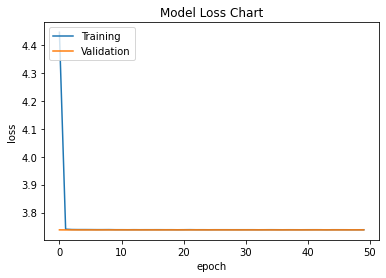

In [18]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['loss'])
plt.plot(trainingHistory.history['val_loss'])

#Chart Tittle
plt.title('Model Loss Chart')

#Chart Labels
plt.ylabel('loss')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

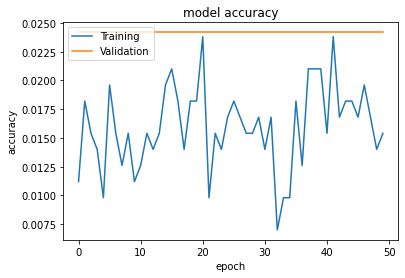

In [19]:
#Loss Chart is being drawn

#Chart Values
plt.plot(trainingHistory.history['accuracy'])
plt.plot(trainingHistory.history['val_accuracy'])

#Chart Tittle
plt.title('model accuracy')

#Chart Labels
plt.ylabel('accuracy')
plt.xlabel('epoch')

#Chart Lines
plt.legend(['Training', 'Validation'], loc='upper left')

#Show Method
plt.show()

In [20]:
#FaceOnly Test data is being read from md5 file
testDf = pd.read_pickle("../../../Data/Above90/FaceOnly/Test.pkl")
testDf

,PersonID,ImageBGR,DetectionType
0,9,"[[[161, 124, 104], [160, 124, 105], [159, 125,...",SingleFace
1,40,"[[[8, 15, 142], [7, 15, 142], [6, 15, 142], [6...",SingleFace
2,6,"[[[129, 179, 225], [128, 179, 223], [127, 179,...",SingleFace
3,19,"[[[219, 200, 195], [219, 200, 195], [221, 201,...",SingleFace
4,28,"[[[141, 161, 218], [140, 160, 218], [138, 159,...",SingleFace
...,...,...,...
121,29,"[[[3, 5, 13], [2, 4, 12], [1, 1, 9], [0, 1, 9]...",SingleFace
122,32,"[[[191, 207, 214], [192, 208, 215], [193, 209,...",NoFace
123,33,"[[[66, 84, 91], [58, 75, 82], [42, 57, 63], [3...",MultipleFace
124,5,"[[[184, 214, 209], [185, 215, 210], [186, 216,...",SingleFace


In [21]:
#testX is being extracted from testDf as wanted shape
#Pixel values are being converted  to the [-1, 1] range with the simplest method (pixel / 127.5 - 1)
testX = (np.array(testDf.ImageBGR.values.tolist()) / 127.5) - 1
testX.shape

(126, 224, 224, 3)

In [22]:
#testY is being extracted from testDf as wanted shape
testY = np.array(testDf.PersonID.values.tolist()).reshape((-1,1))
testY.shape

(126, 1)

In [23]:
#Model is being evaluated with test data
#Sequence class is being also used for evaluation to convert test data into the same format as training data
testResult = model.evaluate(FitSequence(testX, testY, 16))

8/8 [==============================] - 15s 2s/step - loss: 3.7377 - accuracy: 0.0238


In [24]:
#Test Loss is being Printed
print('Test Loss: ' + str(testResult[0]))

Test Loss: 3.7376739978790283


In [25]:
#Test Accuracy is being Printed
print('Test Accuracy: ' + str(testResult[1]))

Test Accuracy: 0.02380952425301075


# Training9 Inference

By looking at the charts, it can be seen that learning does not take place.

The model has not learned enough to have any success even on the Training data, even overfitting did not occur.

Performance can be improved by trying Hyperparameter Optimization methods.

See https://en.wikipedia.org/wiki/Hyperparameter_optimization.